<a href="https://colab.research.google.com/github/Stevey8/CSC2503/blob/main/CSC2503_A1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part II: Implementation Tasks (140 marks)
Assignment 1, CSC2503

In [1]:
# for cv2

# uninstall old wheels
!pip -q uninstall -y opencv-python opencv-python-headless opencv-contrib-python
# install recent, NumPy-2 compatible builds
!pip -q install "opencv-contrib-python-headless>=4.10.0.84" "numpy>=2.0.0"

In [2]:
# run this for all tasks

import os, sys, zipfile, math, random, copy, shutil, time, timm, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
%matplotlib inline
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm, trange
from pathlib import Path

# cv
# 4.5.5.64 is a stable pick where legacy trackers (KCF/MOSSE/CSRT/MIL) are available.
import cv2


# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# run this cell if using GPU
# no need to run if using CPU (eg Q8)

# torch
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize, center_crop
from timm.data import resolve_data_config, create_transform


# Make sure GPU is actually on (Runtime > Change runtime type > GPU)
print("CUDA available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True          # faster convs with fixed input size (224x224)
    torch.set_float32_matmul_precision("high")     # speedup on PyTorch 2.x

seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed)
use_amp = (device.type == 'cuda')
scaler  = torch.amp.GradScaler('cuda', enabled=use_amp)

CUDA available: True
Tesla T4


# [Question 7] Convolutional Neural Networks (100 marks)

In [4]:
# Unzip
dbi_zip = "/content/drive/MyDrive/CSC2503/DBIsubset.zip"
sdd_zip = "/content/drive/MyDrive/CSC2503/SDDsubset.zip"
dbi_dir = "/content/DBIsubset"
sdd_dir = "/content/SDDsubset"

for zip_path, target_dir in [(dbi_zip, dbi_dir), (sdd_zip, sdd_dir)]:
    if os.path.exists(zip_path) and not os.path.exists(target_dir):
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(target_dir)

    # cleanup junk macOS metadata folders if they exist
    junk_dir = os.path.join(target_dir, "__MACOSX")
    if os.path.exists(junk_dir):
        !rm -rf "{junk_dir}"

    # also remove .DS_Store files if present
    !find "{target_dir}" -name ".DS_Store" -delete

def resolve_to_class_root(root):
    entries = [os.path.join(root, e) for e in os.listdir(root)]
    dirs = [d for d in entries if os.path.isdir(d)]
    files = [f for f in entries if os.path.isfile(f)]
    # If there's only one subdir (and no images directly), descend
    if len(dirs) == 1 and not files:
        return dirs[0]
    return root

dbi_root = resolve_to_class_root(dbi_dir)
sdd_root = resolve_to_class_root(sdd_dir)



# utils
batch_size = 32
lr = 1e-3
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=('cuda' if device.type=='cuda' else 'cpu'),
                            dtype=(torch.float16 if device.type=='cuda' else torch.bfloat16),
                            enabled=use_amp):
            logits = model(images)
            loss = criterion(logits, labels)
        if device.type == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc, epochs, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(model_name)
    axs[0].plot(range(1, epochs + 1), train_loss, label='Train')
    axs[0].plot(range(1, epochs + 1), val_loss,   label='Val')
    axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].set_title('Train/Val Loss')
    axs[1].plot(range(1, epochs + 1), train_acc, label='Train')
    axs[1].plot(range(1, epochs + 1), val_acc,   label='Val')
    axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Accuracy'); axs[1].legend(); axs[1].set_title('Train/Val Acc')
    plt.tight_layout(); plt.show()

def report_test_acc(model, test_loader, criterion=criterion, device=device, printout=True):
    _, test_acc = evaluate(model, test_loader, criterion, device)
    if printout:
      print(f"final test accuracy: {test_acc:.3f}")
    return test_acc


## Task I - Inspection (5 marks):

- The DBI subset generally contains fewer images per species, resulting in a smaller sample size, while the SDD subset includes a larger number of images.

- Images in the DBI subset appear more “pure,” consisting almost exclusively of dogs and typically in higher resolution. In contrast, the SDD subset may include other objects such as humans (for example, casual everyday photos), and some images are lower in resolution or do not clearly show the dog’s full front view.

## Task II - simple CNN Training on the DBI (15 marks):
- optimizer: use Adam throughout
- although model loss over epoch is not required by the assignment, it's still included here for reference

In [5]:
# prepare data for simple and resnet from scratch (Task II and III)
img_size = 128

train_transform = transforms.Compose([
    transforms.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomRotation(degrees=15, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset_full = datasets.ImageFolder(root=dbi_root, transform=train_transform)
eval_dataset_full  = datasets.ImageFolder(root=dbi_root, transform=eval_transform)
num_classes = len(train_dataset_full.classes) #7

# Split 70/15/15
g = torch.Generator().manual_seed(seed)
all_indices = torch.randperm(len(train_dataset_full), generator=g).tolist()
n_total = len(all_indices)
n_train = int(0.70 * n_total)
n_val   = int(0.15 * n_total)
train_idx = all_indices[:n_train]
val_idx   = all_indices[n_train:n_train+n_val]
test_idx  = all_indices[n_train+n_val:]

train_set = Subset(train_dataset_full, train_idx)
val_set   = Subset(eval_dataset_full,  val_idx)
test_set  = Subset(eval_dataset_full,  test_idx)

pin = (device.type == 'cuda')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=pin)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=pin)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=pin)

print("Classes:", train_dataset_full.classes)
print(f"Sizes -> train: {len(train_set)}, val: {len(val_set)}, test: {len(test_set)}")


Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']
Sizes -> train: 452, val: 96, test: 98


In [6]:
# simple cnn
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # input size: 128
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128 -> 64

            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32
        )

        # if we uniformly resize all images to 128x128,
        # then we may not need this adaptive avg pooling;
        # however,
        # to avoid hardcoding the flatten size,
        # reduce spatial dims with AdaptiveAvgPool
        # so that channels=8 and spatial becomes 8x8 for stability across input sizes.
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # 32x32 -> 8x8
        flat_dim = 8 * 8 * 8

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flat_dim, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [7]:
%%time
# fit
epochs = 10
hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
    hist['train_loss'].append(tr_loss)
    hist['val_loss'].append(va_loss)
    hist['train_acc'].append(tr_acc)
    hist['val_acc'].append(va_acc)

/tmp/ipython-input-1676069046.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Epoch 01 | train loss 1.9579 acc 0.135 | val loss 1.9392 acc 0.219
Epoch 02 | train loss 1.9413 acc 0.164 | val loss 1.9303 acc 0.146
Epoch 03 | train loss 1.9189 acc 0.184 | val loss 1.8890 acc 0.177
Epoch 04 | train loss 1.8833 acc 0.226 | val loss 1.8414 acc 0.260
Epoch 05 | train loss 1.8383 acc 0.241 | val loss 1.7782 acc 0.240
Epoch 06 | train loss 1.8236 acc 0.254 | val loss 1.7473 acc 0.312
Epoch 07 | train loss 1.7716 acc 0.274 | val loss 1.7159 acc 0.323
Epoch 08 | train loss 1.7223 acc 0.314 | val loss 1.7267 acc 0.281
Epoch 09 | train loss 1.7268 acc 0.281 | val loss 1.6723 acc 0.354
Epoch 10 | train loss 1.7031 acc 0.305 | val loss 1.7802 acc 0.302
CPU times: user 22.9 s, sys: 1.62 s, total: 24.5 s
Wall time: 1min


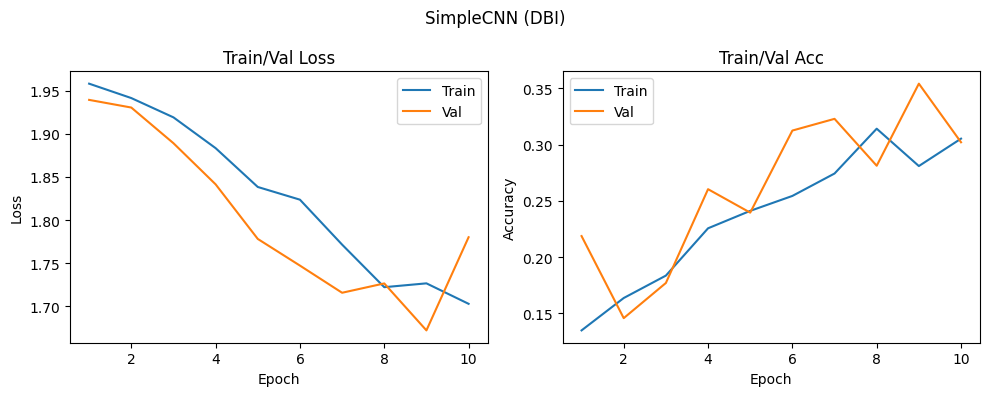

final test accuracy: 0.316


0.3163265306122449

In [8]:
# plot and report for simple CNN (with dropout)
plot_loss_acc(
    hist['train_loss'],
    hist['val_loss'],
    hist['train_acc'],
    hist['val_acc'],
    epochs,
    "SimpleCNN (DBI)")
report_test_acc(model, test_loader)

In [9]:
%%time

# Same CNN but without dropout
class SimpleCNNNoDropout(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        flat_dim = 8 * 8 * 8
        # no drop out
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  # logits

# free VRAM of prior model/optimizer
try:
    del model, optimizer
    torch.cuda.empty_cache()
except NameError:
    pass

# new model + its own optimizer
model = SimpleCNNNoDropout(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

hist2 = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
    hist2['train_loss'].append(tr_loss)
    hist2['val_loss'].append(va_loss)
    hist2['train_acc'].append(tr_acc)
    hist2['val_acc'].append(va_acc)


/tmp/ipython-input-1676069046.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Epoch 01 | train loss 1.9235 acc 0.170 | val loss 1.9360 acc 0.094
Epoch 02 | train loss 1.8303 acc 0.270 | val loss 1.8096 acc 0.302
Epoch 03 | train loss 1.7121 acc 0.334 | val loss 1.7529 acc 0.229
Epoch 04 | train loss 1.6273 acc 0.345 | val loss 1.6600 acc 0.365
Epoch 05 | train loss 1.5665 acc 0.396 | val loss 1.7192 acc 0.229
Epoch 06 | train loss 1.5507 acc 0.398 | val loss 1.7458 acc 0.292
Epoch 07 | train loss 1.5104 acc 0.412 | val loss 1.6927 acc 0.365
Epoch 08 | train loss 1.4941 acc 0.416 | val loss 1.8186 acc 0.302
Epoch 09 | train loss 1.4833 acc 0.458 | val loss 1.6135 acc 0.333
Epoch 10 | train loss 1.4174 acc 0.418 | val loss 1.6297 acc 0.344
CPU times: user 2.99 s, sys: 1.01 s, total: 4.01 s
Wall time: 39.9 s


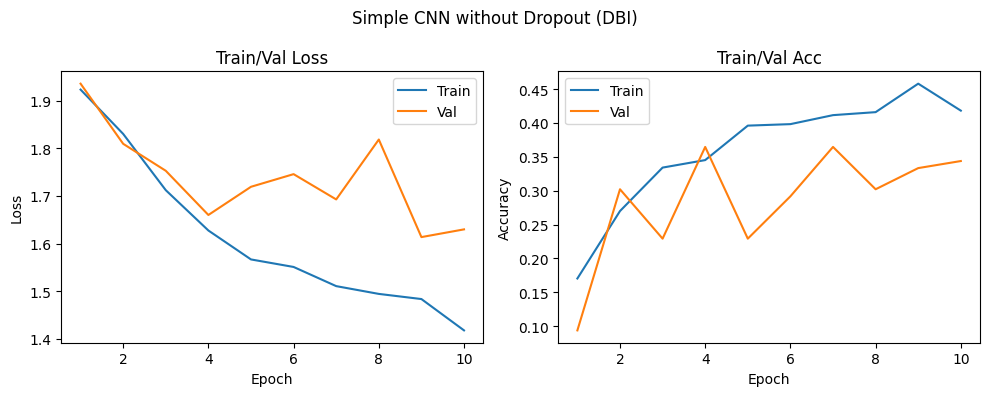

final test accuracy: 0.388


0.3877551020408163

In [10]:
plot_loss_acc(
    hist2['train_loss'],
    hist2['val_loss'],
    hist2['train_acc'],
    hist2['val_acc'],
    epochs=10,
    model_name='Simple CNN without Dropout (DBI)'
)

report_test_acc(model, test_loader)

### Comparison of the Simple CNN With vs. Without Dropout

- **Training accuracy:** Without dropout, the model achieves higher training accuracy, reaching around 0.4–0.45 after the 5th epoch, while with dropout, it only hovers around 0.3.
- **Validation accuracy:** Both the dropout and non-dropout models reach around 0.3–0.35 in validation accuracy.  
- **Overall trend:** When comparing the training and validation accuracy curves, the model without dropout shows signs of potential overfitting. The model with dropout, on the other hand, has more consistent results across the training and validation sets.  
- **Loss:** This is also reflected in the loss-over-epoch plot, where the model without dropout shows a larger gap between the training and validation sets toward the end of training.
- **Generalization to the test set:** While the model without dropout achieves a higher test accuracy (0.388 vs. 0.316), this result may be less reliable since the model is more prone to overfitting.

### NOTE:
- Results (numbers) may look different from the markdown cells vs. the ones from the plot and print statements. This is caused by nondeterministic operations in PyTorch and GPU computations (even that we've set seeds).

## Task III - ResNet Training on the DBI (20 marks):

In [11]:
%%time
# III.a - DBI using ResNet18

# use weights = None so that we train from scratch (not pretrained)
resnet = models.resnet18(weights=None)

# resnet input layer (C1): resnet.conv1
# by defualt its defined as
# nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
# expect (3, 224, 224) but can handle our (3, 128, 128) as well
# so no change needed


# output layer: resnet.fc (fully connected)
# by default:
# nn.Linear(512, num_classes)
in_features = resnet.fc.in_features
# output: 7 classes (this is the one we should change)
num_classes = 7
resnet.fc = nn.Linear(in_features = in_features, out_features = num_classes)


# free VRAM of prior model/optimizer
try:
    del model, optimizer
    torch.cuda.empty_cache()
except NameError:
    pass


model = resnet.to(device)
# add weight decay (1e-4) to optimizer
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

hist3 = {
  'train_loss': [],
  'val_loss': [],
  'train_acc': [],
  'val_acc': []
}
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    hist3['train_loss'].append(tr_loss)
    hist3['val_loss'].append(va_loss)
    hist3['train_acc'].append(tr_acc)
    hist3['val_acc'].append(va_acc)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")


/tmp/ipython-input-1676069046.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Epoch 01 | train loss 1.9733 acc 0.257 | val loss 3.7935 acc 0.219
Epoch 02 | train loss 1.7459 acc 0.296 | val loss 5.0512 acc 0.188
Epoch 03 | train loss 1.5506 acc 0.389 | val loss 2.0205 acc 0.312
Epoch 04 | train loss 1.4637 acc 0.400 | val loss 2.7241 acc 0.302
Epoch 05 | train loss 1.4084 acc 0.436 | val loss 1.9180 acc 0.281
Epoch 06 | train loss 1.2892 acc 0.535 | val loss 1.6747 acc 0.365
Epoch 07 | train loss 1.2302 acc 0.513 | val loss 1.2983 acc 0.458
Epoch 08 | train loss 1.1944 acc 0.562 | val loss 1.5648 acc 0.479
Epoch 09 | train loss 1.1305 acc 0.558 | val loss 1.4739 acc 0.438
Epoch 10 | train loss 1.0563 acc 0.586 | val loss 1.5201 acc 0.458
CPU times: user 24 s, sys: 1.43 s, total: 25.5 s
Wall time: 59.6 s


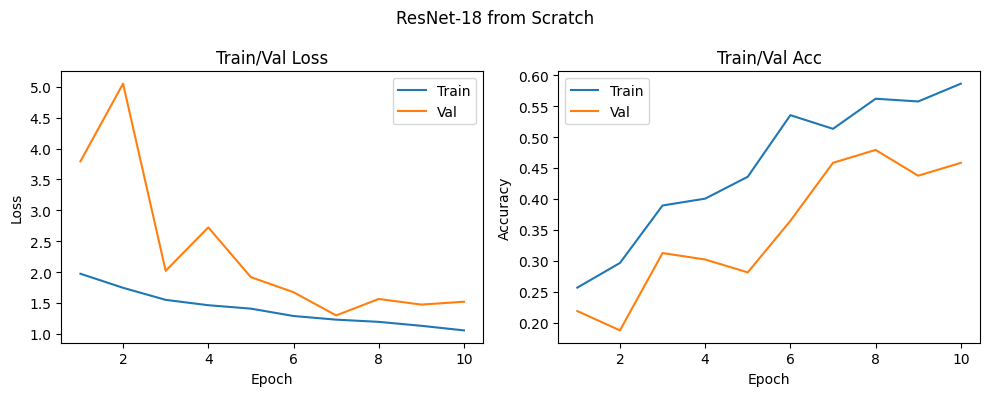

final test accuracy: 0.469


0.46938775510204084

In [12]:
plot_loss_acc(
    hist3['train_loss'],
    hist3['val_loss'],
    hist3['train_acc'],
    hist3['val_acc'],
    epochs=epochs,
    model_name='ResNet-18 from Scratch'
)
report_test_acc(model, test_loader)

### Result Comparison of ResNet-18 (from Scratch) and Simple CNN

- The ResNet-18 model trained from scratch shows a stronger tendency to overfit. Its training accuracy approaches 0.5, while the validation accuracy fluctuates, reaching as high as ~0.45 at epoch 9 but dropping sharply to ~0.3 at epoch 10. On average, the training accuracy is higher than that of the simple CNN models (both with and without dropout), whereas the validation accuracy remains roughly comparable to them.

- The model achieves an even higher test accuracy of 0.48, compared to ~0.32 for the simple CNN with dropout and ~0.39 for the simple CNN without dropout. However, the overfitting issue remains concerning in terms of the model’s generalization power, making the result less reliable despite the higher test performance.


In [13]:
# IIIb. pred entire SDD with trained DBI model
sdd_dataset = datasets.ImageFolder(root=sdd_root, transform=eval_transform)
sdd_loader  = DataLoader(sdd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
report_test_acc(model, test_loader=sdd_loader)

final test accuracy: 0.320


0.32035685320356855

### Brief comparison between DBI (test) and SDD (whole)
- The model achieved a higher test accuracy on the DBI dataset (0.48) compared to its performance on the entire SDD dataset (0.296). The lower accuracy on SDD is expected, as the model trained on DBI is being evaluated on a larger, different dataset, leading to reduced generalization performance.



## Task IV - Fine-tuning on the DBI (25 marks):

In [14]:
# load 224*224 images for Task IV


num_epochs = 3 # use 3 first to check if working without error
lr = 1e-3
weight_decay = 1e-4
num_classes = 7

# most pretrained ImageNet models were trained with this input size,
# ensuring compatible feature scaling.
img_size = 224

# Use ImageNet mean/std normalization so inputs match the distribution
# that pretrained models were originally trained on.
weights = models.ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()
mean, std = transform.mean, transform.std


train_transform = transforms.Compose([
    transforms.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.RandomRotation(15, fill=0),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_full = datasets.ImageFolder(dbi_root, transform=train_transform)
eval_full  = datasets.ImageFolder(dbi_root, transform=eval_transform)

g = torch.Generator().manual_seed(seed)
perm = torch.randperm(len(train_full), generator=g).tolist()
n = len(perm)
n_train = int(0.70*n); n_val = int(0.15*n); n_test = n - n_train - n_val
idx_train = perm[:n_train]
idx_val = perm[n_train:n_train+n_val]
idx_test = perm[n_train+n_val:]

train_set = Subset(train_full, idx_train)   # augmented
val_set = Subset(eval_full,  idx_val)     # deterministic
test_set = Subset(eval_full,  idx_test)    # deterministic

num_workers = 2  # 2–4 is usually fine in Colab
pin = (device.type == "cuda")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin)
val_loader = DataLoader(val_set,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin)
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin)
# also need to report accuracies on SDD whole set
sdd_dataset = datasets.ImageFolder(root=sdd_root, transform=eval_transform)
sdd_loader  = DataLoader(sdd_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin)



In [15]:
%%time
# free VRAM of prior model/optimizer
try:
    del model, optimizer
    torch.cuda.empty_cache()
except NameError:
    pass

# only need to report accuracies in this task (no plotting)
taskIV_accs = {}

def finetune_and_eval(model, name, num_epochs=10, lr=1e-3, wd=1e-4,
                      report_dict=None, cleanup=True, return_model=False):
    model = model.to(device)

    # original optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)


    # if using a higher epoch:
    # Higher LR for the new head (faster convergence in few epochs):

    # head_params = [p for n,p in model.named_parameters() if n.startswith(("fc","head","classifier","heads.head"))]
    # base_params = [p for n,p in model.named_parameters() if not n.startswith(("fc","head","classifier","heads.head"))]
    # optimizer = torch.optim.Adam([
    #     {"params": base_params, "lr": lr},
    #     {"params": head_params, "lr": lr*10},
    # ], weight_decay=wd)


    print(f'training {name}...')
    for _ in trange(num_epochs, desc=name, unit="epoch"):
        _, _ = train_one_epoch(model, train_loader, optimizer, criterion, device)
        _, _ = evaluate(model, val_loader, criterion, device)
    print('')
    print(f'{name} training done')

    results = {
        'dbi_test': report_test_acc(model, test_loader, printout=False),
        'sdd_all':  report_test_acc(model, sdd_loader,  printout=False),
    }
    if report_dict is not None:
        report_dict[name.lower()] = results

    # optional cleanup (only safe if no external references)
    if cleanup:
        del optimizer
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

    return model if return_model else None


print('BELOW: 5 PRE-TRAINED MODELS')

# final layer for resnet and resnext: .fc

# resnet18
print('1. ResNet18 (different from above; this one is pre-trained!)')
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = finetune_and_eval(resnet18, 'ResNet18',
                            #  num_epochs=num_epochs,
                             report_dict=taskIV_accs,
                             cleanup=True, return_model=False)

# resnet34
print('2. ResNet34')
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34 = finetune_and_eval(resnet34, 'ResNet34',
                            #  num_epochs=num_epochs,
                             report_dict=taskIV_accs,
                             cleanup=True, return_model=False)

# resnext50
print('3. ResNeXt50_32x4d')
resnext50 = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
resnext50.fc = nn.Linear(resnext50.fc.in_features, num_classes)
resnext50 = finetune_and_eval(resnext50, 'ResNeXt50_32x4d',
                              # num_epochs=num_epochs,
                              report_dict=taskIV_accs,
                              cleanup=True, return_model=False)

# swin
print('4. Swin-T')
swin_t = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
# final layer: .head
swin_t.head = nn.Linear(swin_t.head.in_features, num_classes)
swin_t = finetune_and_eval(swin_t, 'Swin-T',
                          #  num_epochs=num_epochs,
                           report_dict=taskIV_accs,
                           cleanup=True, return_model=False)

# efficientnet-b0
print('5. EfficientNet-B0')
effb0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
# final layer: .classifier[1]
effb0.classifier[1] = nn.Linear(effb0.classifier[1].in_features, num_classes)
effb0 = finetune_and_eval(effb0, 'EfficientNet-B0',
                          # num_epochs=num_epochs,
                          report_dict=taskIV_accs,
                          cleanup=True, return_model=False)


BELOW: 5 PRE-TRAINED MODELS
1. ResNet18 (different from above; this one is pre-trained!)
training ResNet18...


ResNet18:   0%|          | 0/10 [00:00<?, ?epoch/s]/tmp/ipython-input-1676069046.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
ResNet18: 100%|██████████| 10/10 [01:08<00:00,  6.83s/epoch]


ResNet18 training done


2. ResNet34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]


training ResNet34...


ResNet34: 100%|██████████| 10/10 [00:52<00:00,  5.26s/epoch]


ResNet34 training done


3. ResNeXt50_32x4d
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 166MB/s]


training ResNeXt50_32x4d...


ResNeXt50_32x4d: 100%|██████████| 10/10 [01:15<00:00,  7.58s/epoch]


ResNeXt50_32x4d training done


4. Swin-T
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:01<00:00, 75.4MB/s]


training Swin-T...


Swin-T: 100%|██████████| 10/10 [00:56<00:00,  5.63s/epoch]


Swin-T training done


5. EfficientNet-B0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s] 


training EfficientNet-B0...


EfficientNet-B0: 100%|██████████| 10/10 [02:14<00:00, 13.48s/epoch]


EfficientNet-B0 training done


CPU times: user 3min 56s, sys: 14.6 s, total: 4min 11s
Wall time: 7min 1s


### Report Accuracies (DBI test set & SDD whole set)

In [16]:
# show result with a nice pandas df
df = pd.DataFrame(taskIV_accs).T   # transpose so models are rows
df.index.name = "Model"
df.columns = ["DBI Test Acc", "SDD All Acc"]

print(df)

                 DBI Test Acc  SDD All Acc
Model                                     
resnet18             0.775510     0.642336
resnet34             0.765306     0.577453
resnext50_32x4d      0.867347     0.709651
swin-t               0.836735     0.582320
efficientnet-b0      0.918367     0.763179


### Discussion
- Ranking by generalization: EfficientNet-B0 (78.3%) and ResNeXt50-32x4d (74.1%) generalized better to SDD than the other three models (ResNet-18, ResNet-34, and Swin-T), which all scored below 60%.

- Largest performance gap: ResNet-18 (80.6% → 58.2%) showed the biggest drop from DBI to SDD, indicating weaker robustness to domain shift.

- Smallest gap: EfficientNet-B0 (89.8% → 78.3%) had the smallest drop, suggesting stronger transfer learning capability.


## Task V - Dataset detection (20 marks):

In [17]:
# Task V - Dataset Detection

# process data: label images from DBI and SDD datasets
dbi_root_p = Path(dbi_root)
sdd_root_p = Path(sdd_root)

dbi_imgs = list(dbi_root_p.rglob("*.jpg")) + list(dbi_root_p.rglob("*.png"))
sdd_imgs = list(sdd_root_p.rglob("*.jpg")) + list(sdd_root_p.rglob("*.png"))

# Train/val/test split per domain
def split_list(items, train=0.7, val=0.15, test=0.15):
    items = items[:]  # copy
    random.shuffle(items)
    n = len(items); n_tr = int(n*train); n_va = int(n*val)
    return items[:n_tr], items[n_tr:n_tr+n_va], items[n_tr+n_va:]

dbi_train, dbi_val, dbi_test = split_list(dbi_imgs)
sdd_train, sdd_val, sdd_test = split_list(sdd_imgs)

# Materialize Task-V dataset
taskv_root = Path("/content/DatasetDetect")
for sp in ["train","val","test"]:
    for dom in ["dbi","sdd"]:
        (taskv_root/sp/dom).mkdir(parents=True, exist_ok=True)

def place_files(paths, out_dir: Path, prefix: str):
    for i, p in enumerate(paths):
        dst = out_dir / f"{prefix}_{i}{p.suffix.lower()}"
        shutil.copy2(p, dst)

plan = {
    ("train","dbi"): dbi_train, ("val","dbi"): dbi_val, ("test","dbi"): dbi_test,
    ("train","sdd"): sdd_train, ("val","sdd"): sdd_val, ("test","sdd"): sdd_test,
}
for (sp, dom), paths in plan.items():
    place_files(paths, taskv_root/sp/dom, dom)

print("Train DBI files:", len(list((taskv_root/"train"/"dbi").glob("*"))))
print("Train SDD files:", len(list((taskv_root/"train"/"sdd").glob("*"))))



# Build loaders
img_size = 224
weights = models.ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()
mean, std = transform.mean, transform.std

train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tf  = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(taskv_root/"train", transform=train_tf)
val_ds   = datasets.ImageFolder(taskv_root/"val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(taskv_root/"test",  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", train_ds.classes)
print("Sizes  :", len(train_ds), len(val_ds), len(test_ds))


Train DBI files: 452
Train SDD files: 863
Classes: ['dbi', 'sdd']
Sizes  : 1315 280 284


In [18]:
%%time
num_classes = 2  # DBI vs SDD
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)  # replace head
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-4)
print("Training ResNet18 for Task V (DBI vs SDD)...")

# Use 3 epochs first to verify the training loop runs correctly before longer training.
# num_epochs = 3
num_epochs = 10
for _ in trange(
    num_epochs,
    desc="ResNet18 Task V",
    unit="epoch"
  ):
    tr_loss, tr_acc = train_one_epoch(resnet18, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(resnet18, val_loader, criterion, device)
    print(f"train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
print('training done')


Training ResNet18 for Task V (DBI vs SDD)...


ResNet18 Task V:   0%|          | 0/10 [00:00<?, ?epoch/s]/tmp/ipython-input-1676069046.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
ResNet18 Task V:  10%|█         | 1/10 [00:17<02:36, 17.34s/epoch]

train 0.4373/0.782 | val 0.4587/0.800


ResNet18 Task V:  20%|██        | 2/10 [00:26<01:41, 12.72s/epoch]

train 0.2139/0.925 | val 0.3965/0.811


ResNet18 Task V:  30%|███       | 3/10 [00:36<01:19, 11.42s/epoch]

train 0.1325/0.947 | val 0.3655/0.832


ResNet18 Task V:  40%|████      | 4/10 [00:46<01:03, 10.63s/epoch]

train 0.1050/0.963 | val 0.4311/0.832


ResNet18 Task V:  50%|█████     | 5/10 [00:55<00:50, 10.19s/epoch]

train 0.0590/0.983 | val 0.3498/0.861


ResNet18 Task V:  60%|██████    | 6/10 [01:04<00:39,  9.87s/epoch]

train 0.0300/0.995 | val 0.3724/0.839


ResNet18 Task V:  70%|███████   | 7/10 [01:14<00:29,  9.77s/epoch]

train 0.0174/0.997 | val 0.4240/0.861


ResNet18 Task V:  80%|████████  | 8/10 [01:23<00:19,  9.66s/epoch]

train 0.0229/0.994 | val 0.4544/0.832


ResNet18 Task V:  90%|█████████ | 9/10 [01:33<00:09,  9.62s/epoch]

train 0.0209/0.996 | val 0.5388/0.832


ResNet18 Task V: 100%|██████████| 10/10 [01:42<00:00, 10.28s/epoch]

train 0.0217/0.993 | val 0.5769/0.821
training done
CPU times: user 31.3 s, sys: 3.47 s, total: 34.8 s
Wall time: 1min 43s


### Model Specification & Justification:
- ResNet-18 is used, as it provides a great balance between depth, generalization, and computational efficiency.
- The network was initialized with ImageNet pre-trained weights and the funal fully connected layer was replaced by a linear layer wit h2 output units (DBI vs SDD).
- The model was trained using the Adam optimizer and cross-entropy loss for 10 epochs on the training set.
### Test Accuracy

In [19]:
# accuracy of the test set
report_test_acc(resnet18, test_loader)

final test accuracy: 0.845


0.8450704225352113

## Task VI - How to improve performance on SDD? (10 marks):
- Case 1: At training time, we have access to the entire DBI dataset, but none of the SDD dataset.
All we know is a high level description of SDD and its differences with DBI (similar to
the answer you provided for Task I of this question).
  - If only DBI is available, we can focus on improving model generalization through strong data augmentation (for example, color jitter, random crops, flipping and rotations), and regularization techniques such as dropout and weight decay to simulate SDD's variability.
- Case 2: At training time, we have access to the entire DBI dataset and a small portion (e.g. 10%)
of the SDD dataset.
  - With limited labeled SDD data, a transfer learning strategy can be used: fine-tune the model pre-trained on DBI using the small labeled SDD dataset to align its feature representations with the SDD distributions.
- Case 3: At training time, we have access to the entire DBI dataset and a small portion (e.g.
10%) of the SDD dataset but without the SDD labels for this subset.
  - In this case, we would need to use unsupervised or semi-supervised learning methods, such as self-training, where we first train a model on the labeled DBI data, then let it generate pseudo-labels for the unlabeled SDD images. The model can then be fine-tuned using both real and pseudo-labeled data to gradually adapt to the SDD domain.

## Task VII - Discussion (5 marks):
- This exercise highlights how dataset bias and domain shift can affect model performance. A model trained on one dataset (in our example here, DBI) may perform poorly when evaluated on a different dataset (e.g., SDD) since the learning patterns tied to background, lighting, or image quality rather than the actual subject.
- In real world applications, if we deploy a model trained on one environment (e.g., a university) to anotehr (e.g., a retirement home), the differences can lead to unreliable results. Addressign such issues requries diverse and representative training data, as well as techniques like fine tuning or domain adaptation to ensure the model generalizes beyod the original data source.


### Note: split used in this task
- In this task we used a 70-15-15 train/val/test split.


---
# [Question 8] Tracking Comparison (30 marks)
## Detect the face in the first frame of the video

In [20]:
# load the video from drive
zip_path = "/content/drive/MyDrive/CSC2503/TheOffice.zip"
extract_dir = "/content/TheOffice"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
vid = os.listdir(extract_dir)
print(vid)
video_path = os.path.join(extract_dir, vid[0])
print(video_path)


['TheOffice.mp4']
/content/TheOffice/TheOffice.mp4


In [21]:
# Get the prototxt (network architecture)
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

# Get the pretrained Caffe model (weights)
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# model
net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)


In [22]:
# cv2.VideoCapture: creates a vido capture object that can read frames sequentially
# useful for future projects whenever videos are involved
cap = cv2.VideoCapture(video_path)

# reads the first frame
ret, frame = cap.read()
# ret: bool, whether the read was successful
# frame: np.array, image data of the frame

# note: if reading multiple frames, use a while True + (if not ret: break) to loop thru

# closes the video file and releases system resources
# good practice after done reading
cap.release()

print("Frame shape:", frame.shape)
# shape: (height, width, colour channels BGR)

Frame shape: (360, 640, 3)


In [23]:
h, w = frame.shape[:2]

# Prepare blob (binary large object)
# turn the frame into a 4D tensor with shape (N, C, H, W)
blob = cv2.dnn.blobFromImage(
    image = cv2.resize(frame, (300, 300)), # make sure to fit the model's expected input size
    scalefactor = 1.0,
    size = (300, 300),
    mean = (104.0, 177.0, 123.0),
    swapRB=False,
    crop=False
)
# print(blob.shape)
# expect (N,C,H,W) = (1,3,300,300)

# pass into the NN
net.setInput(blob) # loads the blob into the model

detections = net.forward()
# output: a 4D array (1,1,N,7)
# each of the N detections (proposed faces) has 7 values (the 4th dim):
# 0: batch idx;  1: class ID (1=face);  2: confidence score (0->1)
# 3~6: bounding box coordinates (4 corners) normalized [0,1]
# 3: left (x1);  4: top (y1);  5: right (x2);  6: bottom (y2)

# Get the most confident detection
conf_threshold = 0.5
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > conf_threshold:
        box = detections[0, 0, i, 3:7] * [w, h, w, h]
        (x1, y1, x2, y2) = box.astype("int")
        init_box = (x1, y1, x2 - x1, y2 - y1)  # (x, y, width, height)
        break

print("Initial bounding box:", init_box)


Initial bounding box: (np.int64(392), np.int64(60), np.int64(77), np.int64(117))


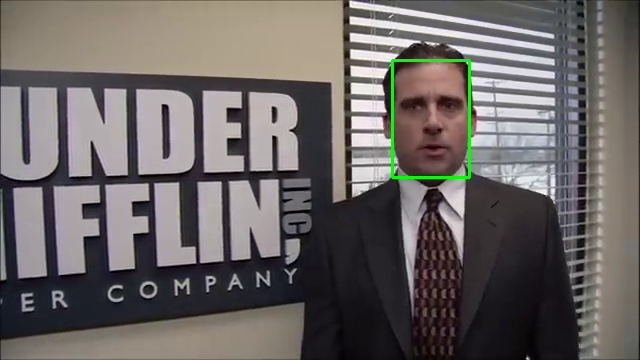

In [24]:
# visualization
frame_vis = frame.copy()
(x, y, w_box, h_box) = init_box
cv2.rectangle(
    img=frame_vis,                    # image to draw on
    pt1=(x, y),                       # top-left corner
    pt2=(x + w_box, y + h_box),       # bottom-right corner
    color=(0, 255, 0),                # BGR
    thickness=2                       # line thickness (*use -1 to fill)
)

from google.colab.patches import cv2_imshow
cv2_imshow(frame_vis)

## 3 Face Tracker & Track through Frames
- trackers used:
  - KCF
  - MOSSE
  - MIL

In [25]:
# utils
def detect_face_dnn(frame, net, conf_thresh=0.5):
    H, W = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    net.setInput(blob)
    dets = net.forward()
    best, best_conf = None, -1.0
    for i in range(dets.shape[2]):
        conf = float(dets[0, 0, i, 2])
        if conf >= conf_thresh and conf > best_conf:
            x1, y1, x2, y2 = (dets[0, 0, i, 3:7] * np.array([W, H, W, H])).astype(int)
            best = (x1, y1, max(0, x2 - x1), max(0, y2 - y1))
            best_conf = conf
    return best

def clip_box_xywh(box, W, H):
    if box is None: return None
    x, y, w, h = map(int, box)
    x = max(0, min(x, W - 1))
    y = max(0, min(y, H - 1))
    w = max(0, min(w, W - x))
    h = max(0, min(h, H - y))
    if w <= 0 or h <= 0: return None
    return (x, y, w, h)

def iou_xywh(a, b):
    if a is None or b is None: return 0.0
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[0]+a[2], b[0]+b[2]); yB = min(a[1]+a[3], b[1]+b[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    union = a[2]*a[3] + b[2]*b[3] - inter
    return float(inter)/union if union > 0 else 0.0

# trackers (KCF, MOSSE, MIL)
def make_tracker(possible_creators):
    """Try multiple possible factory names (legacy / modern) and return the first that works."""
    for name in possible_creators:
        parts = name.split(".")
        mod = cv2
        ok = True
        for p in parts[:-1]:
            if not hasattr(mod, p):
                ok = False
                break
            mod = getattr(mod, p)
        if ok and hasattr(mod, parts[-1]):
            try:
                return getattr(mod, parts[-1])()
            except Exception as e:
                print(f"WARNING: Found {name} but failed to instantiate: {e}")
    return None


def build_trackers():
    tr = {}

    kcf = make_tracker(["legacy.TrackerKCF_create", "TrackerKCF_create"])
    if kcf is not None:
        tr["KCF"] = kcf
    else:
        print("KCF tracker not available in this OpenCV build.")

    mosse = make_tracker(["legacy.TrackerMOSSE_create", "TrackerMOSSE_create"])
    if mosse is not None:
        tr["MOSSE"] = mosse
    else:
        print("MOSSE tracker not available in this OpenCV build.")

    mil = make_tracker(["legacy.TrackerMIL_create", "TrackerMIL_create"])
    if mil is not None:
        tr["MIL"] = mil
    else:
        print("MIL tracker not available in this OpenCV build.")

    # sanity check
    assert len(tr) > 0, "No trackers were successfully built. Install opencv-contrib-python."

    return tr


In [26]:
# check opencv build
print("OpenCV:", cv2.__version__)

# Is the legacy namespace present?
print("has cv2.legacy?    ", hasattr(cv2, "legacy"))

# Does it actually contain the factory functions?
if hasattr(cv2, "legacy"):
    for name in ["TrackerKCF_create", "TrackerMOSSE_create", "TrackerCSRT_create", "TrackerMIL_create"]:
        print(f"has legacy.{name}?", hasattr(cv2.legacy, name))
for name in ["TrackerKCF_create", "TrackerMOSSE_create", "TrackerCSRT_create", "TrackerMIL_create"]:
    print(f"has {name}?", hasattr(cv2, name))

# Optional: confirm build flags
# print(cv2.getBuildInformation())


OpenCV: 4.12.0
has cv2.legacy?     True
has legacy.TrackerKCF_create? True
has legacy.TrackerMOSSE_create? True
has legacy.TrackerCSRT_create? True
has legacy.TrackerMIL_create? True
has TrackerKCF_create? True
has TrackerMOSSE_create? False
has TrackerCSRT_create? True
has TrackerMIL_create? True


In [27]:
trackers = build_trackers()
print("Trackers:", list(trackers.keys()))

# open video and keep it open
cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), "Failed to open video"

# find an initial detection within the first few frames
init_box, init_frame = None, None
probe_limit = 30
for _ in range(probe_limit):
    ret, f = cap.read()
    if not ret: break
    box = detect_face_dnn(f, net, conf_thresh=0.5)
    if box is not None:
        H, W = f.shape[:2]
        init_box = clip_box_xywh(box, W, H)
        init_frame = f.copy()
        break

# make sure there is face
assert init_box is not None, f"No face detected in the first {probe_limit} frames"
print("Initial bounding box:", init_box)

# re-seek to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# init trackers
for name, tr in trackers.items():
    ok = tr.init(init_frame, tuple(map(int, init_box)))
    print(f"{'[OK ]' if ok else '[FAIL]'} init {name}")

# storage
ious_over_time = {name: [] for name in trackers}
ref_frame_indices = []
pred_boxes_last = {name: init_box for name in trackers}
fps_timers = {name: [] for name in trackers}


Trackers: ['KCF', 'MOSSE', 'MIL']
Initial bounding box: (392, 60, 77, 117)
[OK ] init KCF
[OK ] init MOSSE
[OK ] init MIL


In [28]:
# loop through the video
frame_idx = 0
ref_stride = 5

while True:
    ret, frame = cap.read()
    if not ret:
        break

    H, W = frame.shape[:2]

    # update trackers
    for name, tr in trackers.items():
        t0 = time.perf_counter() # performance counter
        # record precise start time for performance measurement

        ok, box = tr.update(frame)
        t1 = time.perf_counter()
        fps_timers[name].append(t1 - t0)
        pred_boxes_last[name] = clip_box_xywh(box if ok else None, W, H)

    # reference every 5th
    if frame_idx % ref_stride == 0:
        # ground truth with cv2.dnn.readNetFromCaffe
        gt_box = clip_box_xywh(detect_face_dnn(frame, net, conf_thresh=0.5), W, H)
        ref_frame_indices.append(frame_idx)

        # trackers
        for name in trackers.keys():
            ious_over_time[name].append(iou_xywh(pred_boxes_last[name], gt_box))

    frame_idx += 1

cap.release()
print(f"Processed {frame_idx} frames; reference frames: {len(ref_frame_indices)}")

Processed 289 frames; reference frames: 58


## Intersection over Union (IoU)
Calculate the intersection over union (IoU) between each tracker’s predicted bounding
box and the ground truth for these reference frames.

In [29]:
# Average IoU
avg_iou = {name: (np.mean(vals) if len(vals) > 0 else 0.0)
           for name, vals in ious_over_time.items()}

# use IoU > 0.8 to determine higher quality tracking results
count_over_08 = {name: int(np.sum(np.array(vals) > 0.8))
                 for name, vals in ious_over_time.items()}

# FPS (median FPS over all frames for stability)
fps = {name: (len(timers)/np.sum(timers) if np.sum(timers) > 0 else 0.0)
       for name, timers in fps_timers.items()}

# print("Average IoU:", avg_iou)
# print("Frames with IoU>0.8:", count_over_08)
# print("FPS (approx):", fps)

# display table will be shown towards the end of this task (stay tuned!)

## Compariosn Plot: IoU over time for all 3 Trackers

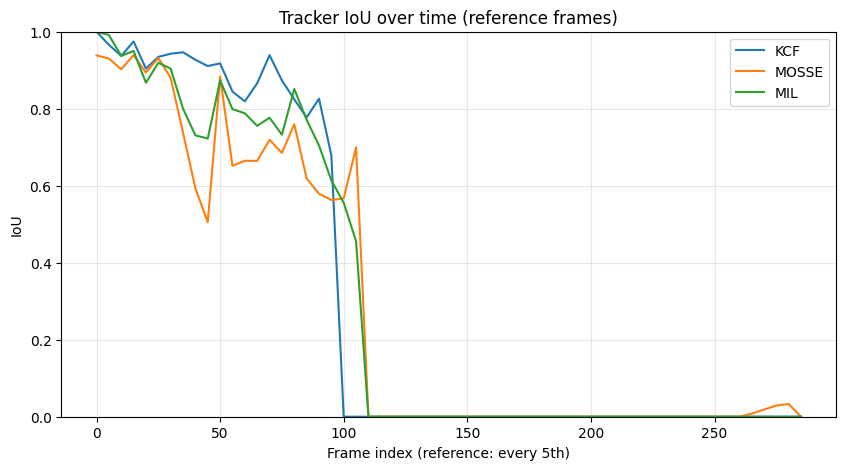

In [30]:
# comparison plot showing IoU over time for all three trackers
plt.figure(figsize=(10,5))
for name, vals in ious_over_time.items():
    plt.plot(ref_frame_indices, vals, label=name)
plt.xlabel("Frame index (reference: every 5th)")
plt.ylabel("IoU")
plt.ylim(0, 1.0)
plt.title("Tracker IoU over time (reference frames)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Qualitative Analysis
- 2 critical frames
  - a frame where face tracking is challenging: frame 170
  - a frame where face tracking is straightforward: frame 25

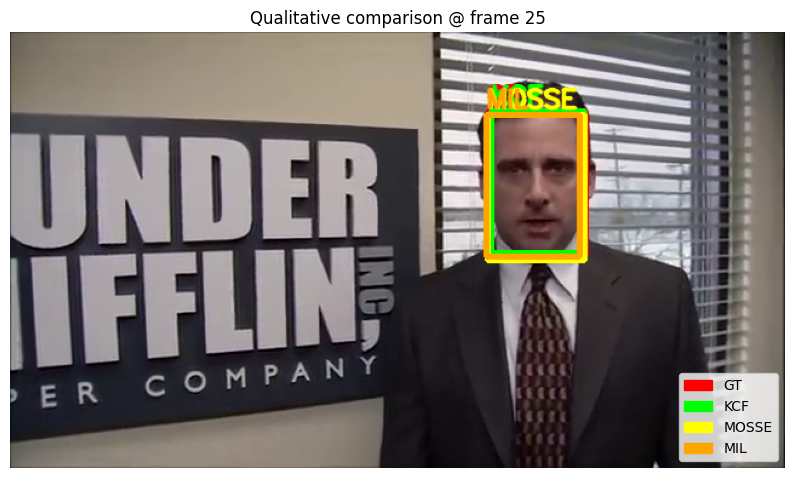

Saved: /content/qualitative_frame_25.png


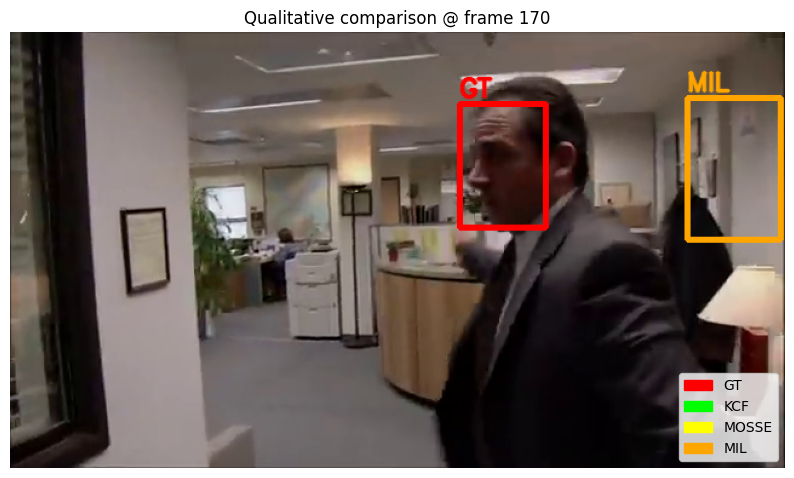

Saved: /content/qualitative_frame_170.png


In [31]:
# OpenCV colors (BGR)
BOX_COLORS = {
    "GT":    (0,   0, 255),     # Red
    "KCF":   (0, 255,   0),     # Green
    "MOSSE": (0, 255, 255),     # Yellow
    "MIL":   (0, 165, 255),     # Orange
}

# Matplotlib colors (RGB)
LEGEND_COLORS = {
    "GT":    (1.0, 0.0, 0.0),     # Red
    "KCF":   (0.0, 1.0, 0.0),     # Green
    "MOSSE": (1.0, 1.0, 0.0),     # Yellow
    "MIL":   (1.0, 0.647, 0.0),   # Orange
}

def build_trackers_fresh():
    """Rebuild fresh tracker instances (so prior state from earlier loop doesn't leak)."""
    tr = {}
    # KCF
    kcf = None
    for path in ["legacy.TrackerKCF_create", "TrackerKCF_create"]:
        mod = cv2.legacy if path.startswith("legacy") and hasattr(cv2, "legacy") else cv2
        fn = path.split(".")[-1]
        if hasattr(mod, fn):
            kcf = getattr(mod, fn)()
            break
    if kcf is not None: tr["KCF"] = kcf

    # MOSSE
    mosse = None
    for path in ["legacy.TrackerMOSSE_create", "TrackerMOSSE_create"]:
        mod = cv2.legacy if path.startswith("legacy") and hasattr(cv2, "legacy") else cv2
        fn = path.split(".")[-1]
        if hasattr(mod, fn):
            mosse = getattr(mod, fn)()
            break
    if mosse is not None: tr["MOSSE"] = mosse

    # MIL
    mil = None
    for path in ["legacy.TrackerMIL_create", "TrackerMIL_create"]:
        mod = cv2.legacy if path.startswith("legacy") and hasattr(cv2, "legacy") else cv2
        fn = path.split(".")[-1]
        if hasattr(mod, fn):
            mil = getattr(mod, fn)()
            break
    if mil is not None: tr["MIL"] = mil

    return tr

def draw_xywh(img, box, color_bgr, label=None, thickness=3):
    if box is None: return img
    x, y, w, h = [int(v) for v in box]
    cv2.rectangle(img, (x, y), (x+w, y+h), color_bgr, thickness)
    if label:
        cv2.putText(img, label, (x, max(0, y-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_bgr, 2, cv2.LINE_AA)
    return img

def grab_frames_with_overlays(video_path, wanted_indices, net, conf_thresh=0.5, probe_limit=30):
    """
    Replays the video, initializes trackers from the first detected frame,
    then captures overlays at the requested frame indices.
    Returns dict: {frame_idx: (BGR image with overlays, raw per-box dict)}
    """
    wanted_indices = sorted(set(int(i) for i in wanted_indices))
    captures = {}
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Failed to open video"

    # Find an initial detection to bootstrap trackers
    init_box, init_frame = None, None
    for _ in range(probe_limit):
        ok, f = cap.read()
        if not ok: break
        box = detect_face_dnn(f, net, conf_thresh=conf_thresh)
        if box is not None:
            H, W = f.shape[:2]
            init_box = clip_box_xywh(box, W, H)
            init_frame = f.copy()
            break
    assert init_box is not None, f"No face detected in the first {probe_limit} frames to initialize trackers."

    # Rewind and init fresh trackers
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    trackers_local = build_trackers_fresh()
    for name, tr in trackers_local.items():
        _ok = tr.init(init_frame, tuple(map(int, init_box)))

    frame_idx = 0
    wanted_ptr = 0  # pointer into wanted_indices
    next_target = wanted_indices[wanted_ptr] if wanted_indices else None

    while True:
        ok, frame = cap.read()
        if not ok: break

        H, W = frame.shape[:2]
        # Update all trackers
        pred_boxes = {}
        for name, tr in trackers_local.items():
            ok_tr, box = tr.update(frame)
            pred_boxes[name] = clip_box_xywh(box if ok_tr else None, W, H)

        # If this frame is one of the requested indices, assemble overlays
        if next_target is not None and frame_idx == next_target:
            gt = clip_box_xywh(detect_face_dnn(frame, net, conf_thresh=conf_thresh), W, H)

            canvas = frame.copy()
            # Draw GT first (red), then trackers
            draw_xywh(canvas, gt, BOX_COLORS["GT"], "GT")
            for name in ["KCF", "MOSSE", "MIL"]:
                if name in pred_boxes:
                    draw_xywh(canvas, pred_boxes[name], BOX_COLORS[name], name)

            captures[frame_idx] = (canvas, {"GT": gt, **pred_boxes})

            # advance pointer
            wanted_ptr += 1
            next_target = wanted_indices[wanted_ptr] if wanted_ptr < len(wanted_indices) else None

        # Early stop if we already captured all targets
        if next_target is None:
            break

        frame_idx += 1

    cap.release()
    return captures

# run for frames 25 (easy) and 170 (challenging)
critical_frames = [25, 170]
captures = grab_frames_with_overlays(video_path, critical_frames, net, conf_thresh=0.5)

# Visualize
for idx in critical_frames:
    if idx not in captures:
        print(f"[WARN] Did not capture frame {idx} (video may be shorter).")
        continue

    bgr_img, boxes = captures[idx]
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title(f"Qualitative comparison @ frame {idx}")

    legend_patches = []
    for key in ["GT", "KCF", "MOSSE", "MIL"]:
        if key in boxes:
            legend_patches.append(Patch(color=LEGEND_COLORS[key], label=key))
    if legend_patches:
        plt.legend(handles=legend_patches, loc='lower right')

    out_path = f"/content/qualitative_frame_{idx}.png"
    plt.savefig(out_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"Saved: {out_path}")


## Summary Table

In [32]:
# display with a nice pandas df
df = pd.DataFrame({
    'Average IoU': avg_iou,
    'Frames IoU > 0.8': count_over_08,
    'FPS': fps
}).reset_index().rename(columns={'index': 'Tracker'})

df['Average IoU'] = df['Average IoU'].round(3)
df['FPS'] = df['FPS'].round(2)

print(df.to_string(index=False))

Tracker  Average IoU  Frames IoU > 0.8    FPS
    KCF        0.307                18 213.61
  MOSSE        0.283                 8 963.78
    MIL        0.302                10  16.51


## Reasons for choosing MOSSE and MIL
- MOSSE: a very fast correlation-based tracker that performs real-time tracking even on CPUs. It is an ideal candidate as it provides a baseline for lightweight, high speed tracking. In the summary table above, this is reflected by its high frames per second (~1000FPS).
- MIL: a robust learning-based tracker (as opposed to KCF and MOSSE which are correlation-based trackers), which updates its model online by considering multiple candidate patches around the target, making it less sensitive to occasional mis-detections or partial occlusions. An evidence is that at frame 170 (heavily impacted by motion blur and partial occlusion), MIL still produced a bounding box while the other two trackers failed to (althogh this bounding box was not accurate).

## Analysis and Discussion
### Ranking and Performance Evaluation
- Based on both the average IoU and the number of frames achieving IoU > 0.8, the overall ranking is: KCF > MIL > MOSSE. KCF demonstrated the most stable tracking and maintained the highest overlap with ground truth across frames. MIL followed closely but showed slight drift during faster head motions. Although MOSSE had the lowest IoU, it ran significantly faster—about five times the speed of the other two—making it highly efficient for real-time use where accuracy can be traded for speed.

- In terms of failure modes, all three trackers (and even the ground-truth detector) performed well in the straightforward frame 25 (frontal face, good lighting). However, in the challenging frame 170 (motion blur and partial occlusion), the ground-truth detector successfully captured the face while all trackers failed to locate the face accurately; MIL produced a bounding box but far from the actual position. This indicates that all trackers struggle under blur and occlusion, with MOSSE being most sensitive to appearance changes.

### Practical Recommendations
- For video conferencing or augmented reality, where accuracy and stability are key, KCF is the most suitable due to its balance of precision and moderate speed.
- For surveillance applications, MOSSE is preferred because of its extremely high processing speed, making it ideal for real-time multi-camera monitoring.

---
# Q9

(np.float64(-0.5), np.float64(499.5), np.float64(336.5), np.float64(-0.5))

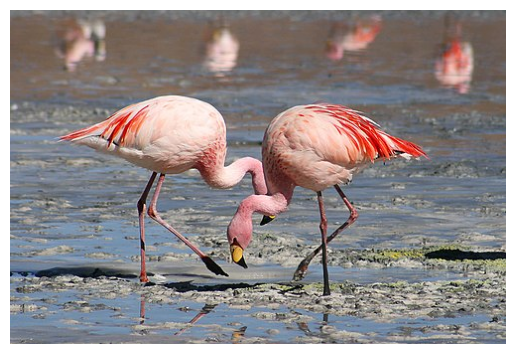

In [33]:
# image
flamingos_path = "/content/drive/MyDrive/CSC2503/Flamingos.jpg"
assert os.path.exists(flamingos_path), f"Not found: {flamingos_path}"

flamingos = cv2.imread(flamingos_path)
flamingos = cv2.cvtColor(flamingos, cv2.COLOR_BGR2RGB) # RGB image
flamingos = Image.fromarray(flamingos) # PIL (for transforms)

import matplotlib.pyplot as plt
plt.imshow(flamingos); plt.axis('off')

In [34]:
# two pre-trained models: resnet18 and swin-small
# Report the predicted class and confidence score for the flamingo image

device = "cuda" if torch.cuda.is_available() else "cpu"

# resnet18
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18 = resnet18.to(device)
resnet18.eval()
resnet18_tfms = models.ResNet18_Weights.DEFAULT.transforms()

# don't track gradients (we only need predictions)
with torch.no_grad():
    x = resnet18_tfms(flamingos).unsqueeze(0).to(device)
    logits = resnet18(x)
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)

# Class names from torchvision meta (aligned to ImageNet-1k)
imagenet_classes = models.ResNet18_Weights.DEFAULT.meta["categories"]
pred_name = imagenet_classes[pred.item()]
print(f"[ResNet18] Top-1: {pred_name}")
print(f"Confidence: {conf.item():.4f}")


# swin small
swin_small = timm.create_model("swin_small_patch4_window7_224",
                                     pretrained=True)
swin_small = swin_small.to(device)
swin_small.eval()

cfg = resolve_data_config({}, model=swin_small)
swin_tfms = create_transform(**cfg, is_training=False)

with torch.no_grad():
    x_swin = swin_tfms(flamingos).unsqueeze(0).to(device)
    logits_swin = swin_small(x_swin)
    probs_swin = F.softmax(logits_swin, dim=1)
    conf_swin, pred_swin = probs_swin.max(dim=1)

# Reuse torchvision's label list for names (indexing matches ImageNet-1k)
pred_name_swin = imagenet_classes[pred_swin.item()]
print(f"[Swin-Small] Top-1: {pred_name_swin}")
print(f"Confidence: {conf_swin.item():.4f}")

[ResNet18] Top-1: flamingo
Confidence: 0.9911


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[Swin-Small] Top-1: flamingo
Confidence: 0.9245


In [35]:
# imagenet class 776
imagenet_classes = models.ResNet18_Weights.DEFAULT.meta["categories"]
print(776, imagenet_classes[776]) # sax = saxophone

776 sax


[ResNet BEFORE] 130 flamingo conf=0.8461
ResNet iter 1/40 targetCE=12.3915 -> pred 611 jigsaw puzzle conf=0.0168
ResNet iter 10/40 targetCE=0.0094 -> pred 776 sax conf=0.9923
Reached high confidence for target on ResNet; stopping early.
[ResNet AFTER] 776 sax conf=0.9923


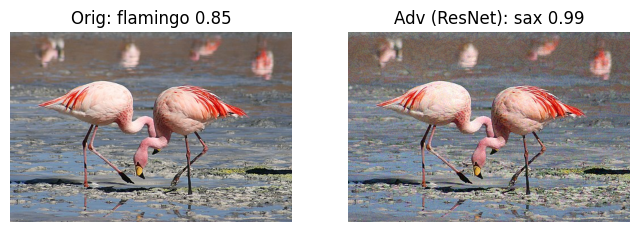

[Swin BEFORE] 130 flamingo conf=0.9022
Swin iter 1/40 loss=9.9157 -> pred 130 flamingo conf=0.4510
Swin iter 10/40 loss=0.1116 -> pred 776 sax conf=0.9345
Reached high confidence for target on Swin; stopping early.
[Swin AFTER] 776 sax conf=0.9345


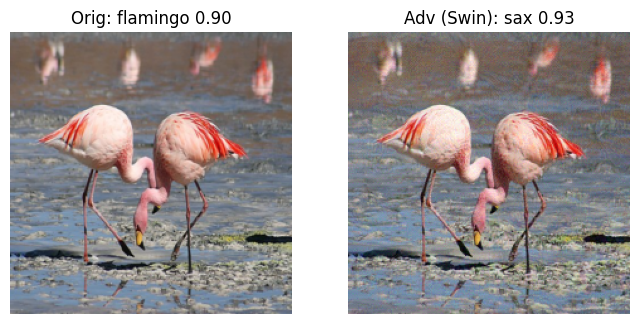

In [36]:
# generate an adversarial example -> imagenet class 776 - sax (saxophone)
target_idx = 776
eps = 8/255.0
alpha = 2/255.0
num_iters = 40

# utils
def predict_from_pixels(model, x_pixels, mean, std, idx_to_name=None):
    """
    x_pixels: tensor shape (1,3,H,W) with values in [0,1] on device
    mean/std: sequences of 3 floats
    """
    model.eval()
    # normalize
    mean_t = torch.tensor(mean, device=x_pixels.device).view(1,3,1,1)
    std_t  = torch.tensor(std,  device=x_pixels.device).view(1,3,1,1)
    x_norm = (x_pixels - mean_t) / std_t
    with torch.no_grad():
        logits = model(x_norm)
        probs = F.softmax(logits, dim=1)
        conf, idx = probs.max(dim=1)
        idx = int(idx.item()); conf = float(conf.item())
    name = None
    if idx_to_name:
        name = idx_to_name[idx]
    return idx, conf, name

# resnet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device).eval()
tv_weights = models.ResNet18_Weights.DEFAULT
tv_tfms = tv_weights.transforms()
imagenet_classes = tv_weights.meta["categories"]
# try to get mean and std from torch vision
mean_tv = tv_weights.meta.get("mean", [0.485,0.456,0.406])
std_tv  = tv_weights.meta.get("std",  [0.229,0.224,0.225])

# build pixel-space tensor in [0,1] (no normalization yet)
to_tensor = transforms.ToTensor()
x_orig_pixels = to_tensor(flamingos).unsqueeze(0).to(device)  # shape (1,3,H,W) in [0,1]

# print original pred
idx_res_before, conf_res_before, name_res_before = predict_from_pixels(resnet,
                                                                       x_orig_pixels,
                                                                       mean_tv,
                                                                       std_tv,
                                                                       imagenet_classes
                                                                       )
print(f"[ResNet BEFORE] {idx_res_before} {name_res_before} conf={conf_res_before:.4f}")

# attack: targeted - minimize cross entropy (CE) with target_idx
x_adv = x_orig_pixels.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([x_adv], lr=0.02)  # lr in pixel space; adapt if needed

for it in range(num_iters):
    optimizer.zero_grad()
    # normalize inside
    mean_t = torch.tensor(mean_tv, device=device).view(1,3,1,1)
    std_t  = torch.tensor(std_tv, device=device).view(1,3,1,1)
    x_norm = (x_adv - mean_t) / std_t
    logits = resnet(x_norm)
    loss = F.cross_entropy(logits, torch.tensor([target_idx], device=device))
    loss.backward()
    optimizer.step()

    # project back into L_inf ball around original and into [0,1]
    with torch.no_grad():
        delta = torch.clamp(x_adv - x_orig_pixels, min=-eps, max=eps)
        x_adv.data = torch.clamp(x_orig_pixels + delta, 0.0, 1.0)

    # print progress
    if (it+1) % 10 == 0 or it == 0:
        pred_idx, conf, name = predict_from_pixels(resnet, x_adv.detach(), mean_tv, std_tv, imagenet_classes)
        print(f"ResNet iter {it+1}/{num_iters} targetCE={loss.item():.4f} -> pred {pred_idx} {name} conf={conf:.4f}")
        # stop early if already target with high conf
        if pred_idx == target_idx and conf > 0.90:
            print("Reached high confidence for target on ResNet; stopping early.")
            break

idx_res_after, conf_res_after, name_res_after = predict_from_pixels(resnet,
                                                                    x_adv.detach(),
                                                                    mean_tv,
                                                                    std_tv,
                                                                    imagenet_classes
                                                                    )
print(f"[ResNet AFTER] {idx_res_after} {name_res_after} conf={conf_res_after:.4f}")

# visualize adversarial image
adv_np = (x_adv.detach().cpu().squeeze().permute(1,2,0).numpy() * 255).astype(np.uint8)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"Orig: {name_res_before} {conf_res_before:.2f}")
plt.axis('off')
plt.imshow(flamingos)
plt.subplot(1,2,2)
plt.title(f"Adv (ResNet): {name_res_after} {conf_res_after:.2f}")
plt.axis('off'); plt.imshow(adv_np)
plt.show()

# swin-small
swin = timm.create_model("swin_small_patch4_window7_224", pretrained=True).to(device).eval()
cfg = timm.data.resolve_data_config({}, model=swin)
from timm.data import create_transform
swin_tfms = create_transform(**cfg, is_training=False)
mean_swin = cfg.get("mean", [0.485,0.456,0.406])
std_swin  = cfg.get("std",  [0.229,0.224,0.225])
# to get imagenet names we reuse torchvision's list (indexes match)
# build pixel-space tensor for swin attack (resize/crop to model input size)
# create_transform includes resizing + center crop + to tensor + normalize, but we want pixel-space
# so create a simple resize+center crop + to_tensor pipeline to generate pixel tensor of correct size:

img_size = cfg.get('input_size', (3,224,224))[1]  # height/width
flamingos_resized = flamingos.resize((img_size, img_size), Image.BILINEAR)
x_orig_pixels_swin = transforms.ToTensor()(flamingos_resized).unsqueeze(0).to(device)

idx_swin_before, conf_swin_before, name_swin_before = predict_from_pixels(swin,
                                                                          x_orig_pixels_swin,
                                                                          mean_swin, std_swin,
                                                                          imagenet_classes
                                                                          )
print(f"[Swin BEFORE] {idx_swin_before} {name_swin_before} conf={conf_swin_before:.4f}")

# Attack Swin similarly
x_adv_swin = x_orig_pixels_swin.clone().detach().requires_grad_(True)
opt_s = torch.optim.Adam([x_adv_swin], lr=0.02)

for it in range(num_iters):
    opt_s.zero_grad()
    mean_t = torch.tensor(mean_swin, device=device).view(1,3,1,1)
    std_t  = torch.tensor(std_swin,  device=device).view(1,3,1,1)
    x_norm = (x_adv_swin - mean_t) / std_t
    logits = swin(x_norm)
    loss = F.cross_entropy(logits, torch.tensor([target_idx], device=device))
    loss.backward()
    opt_s.step()
    with torch.no_grad():
        delta = torch.clamp(x_adv_swin - x_orig_pixels_swin, min=-eps, max=eps)
        x_adv_swin.data = torch.clamp(x_orig_pixels_swin + delta, 0.0, 1.0)

    if (it+1) % 10 == 0 or it == 0:
        pred_idx, conf, name = predict_from_pixels(swin,
                                                   x_adv_swin.detach(),
                                                   mean_swin,
                                                   std_swin,
                                                   imagenet_classes
                                                   )
        print(f"Swin iter {it+1}/{num_iters} loss={loss.item():.4f} -> pred {pred_idx} {name} conf={conf:.4f}")
        if pred_idx == target_idx and conf > 0.90:
            print("Reached high confidence for target on Swin; stopping early.")
            break

idx_swin_after, conf_swin_after, name_swin_after = predict_from_pixels(swin,
                                                                       x_adv_swin.detach(),
                                                                       mean_swin,
                                                                       std_swin,
                                                                       imagenet_classes
                                                                       )
print(f"[Swin AFTER] {idx_swin_after} {name_swin_after} conf={conf_swin_after:.4f}")

adv_np_swin = (x_adv_swin.detach().cpu().squeeze().permute(1,2,0).numpy() * 255).astype(np.uint8)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"Orig: {name_swin_before} {conf_swin_before:.2f}")
plt.axis('off')
plt.imshow(flamingos_resized)
plt.subplot(1,2,2)
plt.title(f"Adv (Swin): {name_swin_after} {conf_swin_after:.2f}")
plt.axis('off')
plt.imshow(adv_np_swin)
plt.show()


---
# END OF ASSIGNMENT


In [37]:
# !find "/content/drive/MyDrive" -name "CSC2503-A1.ipynb"

In [38]:
# git location
# /content/drive/MyDrive/Colab Notebooks

In [39]:
import nbformat, pathlib

# Path to your notebook
nb_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CSC2503-A1.ipynb")

# Load the notebook
nb = nbformat.read(nb_path, as_version=4)

# Remove the broken metadata key if present
if "widgets" in nb.metadata:
    print("Removing metadata.widgets ...")
    del nb.metadata["widgets"]

# Save the cleaned notebook
nbformat.write(nb, nb_path)
# print(f"Fixed and saved: {nb_path}")
